**Install & import Required Libraries**

In [2]:
!pip install category_encoders
!pip install pandas
!pip install scikit-learn  
!pip install numpy       
!pip install matplotlib   

   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.0 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.0 MB 1.1 MB/s eta 0:00:07
   --- ------------------------------------ 0.8/8.0 MB 1.2 MB/s eta 0:00:07
   --- ------------------------------------ 0.8/8.0 MB 1.2 MB/s eta 0:00:07
   ----- ---------------------------------- 1.0/8.0 MB 932.9 kB/s eta 0:00:08
   ------ --------------------------------- 1.3/8.0 MB 987.4 kB/s eta 0:00:07
   ------- -------------------------------- 1.6/8.0 MB 1.1 MB/s eta 0:00:07
   --------- ------------------------------ 1.8/8.0 MB 1.1 MB/s eta 0:00:06
   --------- ------------------------------ 1.8/8.0 MB 1.1 MB/s eta 0:00:06
   ---------- ----------------------------- 2.1/8.0 MB 939.6 kB/s eta 0:00:07
   ---------- ----------------------------- 2.1/8.0 MB 939.6 kB/s eta 0:00:07
   ----------- ----------

In [4]:
!pip install seaborn

In [7]:
!pip install xgboost

  Using cached xgboost-2.1.4-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 764.3 kB/s eta 0:02:43
   ---------------------------------------- 0.8/124.9 MB 907.1 kB/s eta 0:02:17
   ---------------------------------------- 0.8/124.9 MB 907.1 kB/s eta 0:02:17
   ---------------------------------------- 0.8/124.9 MB 907.1 kB/s eta 0:02:17
   ---------------------------------------- 1.0/124.9 MB 699.0 kB/s eta 0:02:58
   ---------------------------------------- 1.0/124.9 MB 699.0 kB/s eta 0:02:58
   ---------------------------------------- 1.0/124.9 MB 699.0 kB/s eta 0:02:58
   ---------------------------------------- 1.0/124.9 MB 699.0 kB/s eta 0:02:58
   ---------------------------------------- 1.3/124.9 MB 554.8 kB/s eta 0:03:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


import category_encoders as ce
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

**Data Understanding**

In [2]:
df = pd.read_csv("/Users/ASUS/Downloads/first inten project.csv")

print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

**Feature Engineering & Selection**

In [3]:
df.columns = df.columns.str.strip()
df['date of reservation'] = pd.to_datetime(df['date of reservation'], errors='coerce')
df.dropna(inplace=True)  # Drop rows with invalid dates

df["year"] = df["date of reservation"].dt.year.astype(int)
df["month"] = df["date of reservation"].dt.month.astype(int)

df["is_weekend"] = df["date of reservation"].dt.weekday.isin([5, 6]).astype(int)

df['total_nights'] = df['number of weekend nights'] + df['number of week nights']

df['guest_type'] = df.apply(lambda x: 'Family' if x['number of children'] > 0 else 'Individual/Couple', axis=1)

df.drop(columns=["date of reservation", 'P-C', 'P-not-C', 'Booking_ID', 'number of adults', 'number of children',
                'number of weekend nights', 'number of week nights'], inplace=True)

In [4]:
label_encoder = LabelEncoder()
df["booking_status"] = label_encoder.fit_transform(df["booking status"])
df.drop(columns=["booking status"], inplace=True)

In [5]:
df["guest_type"] = label_encoder.fit_transform(df["guest_type"])

target_encoder = ce.TargetEncoder(cols=["market segment type"])
df["market_segment_encoded"] = target_encoder.fit_transform(df["market segment type"], df["booking_status"])
df.drop(columns=["market segment type"], inplace=True)
df_encoded = pd.get_dummies(df, columns=['room type', 'type of meal'])

In [6]:
columns_to_scale = ['lead time', 'average price', 'total_nights']
scaler = RobustScaler()
df_scaled = df_encoded.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_encoded[columns_to_scale])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19952\1262543228.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=status_percentage.index, y=status_percentage, palette=['#ff9999', '#66b3ff'])


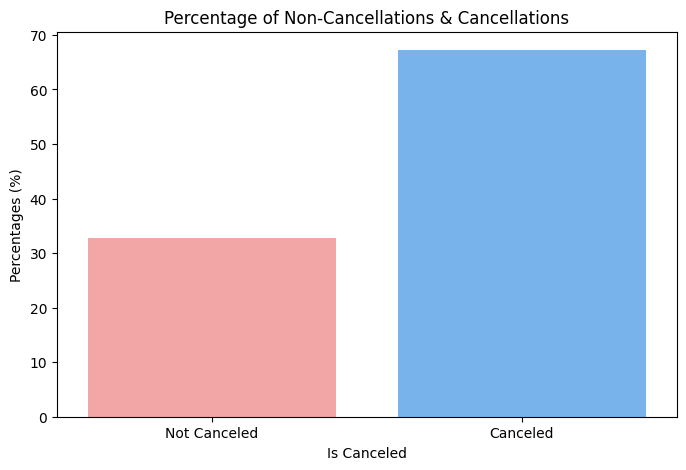

In [7]:
status_percentage = df_encoded['booking_status'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=status_percentage.index, y=status_percentage, palette=['#ff9999', '#66b3ff'])
plt.title('Percentage of Non-Cancellations & Cancellations')
plt.xlabel('Is Canceled')
plt.ylabel('Percentages (%)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.yticks(ticks=range(0, 80, 10))

plt.show()

**Train-test split**

In [8]:
X = df_scaled.drop(columns='booking_status', axis=1)
y = df_scaled['booking_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**XGBoost Classifier**

In [9]:
from sklearn.metrics import classification_report
import xgboost as xgb

# Assuming X_train, X_test, y_train, y_test are already defined
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      2377
           1       0.89      0.92      0.91      4873

    accuracy                           0.87      7250
   macro avg       0.86      0.85      0.85      7250
weighted avg       0.87      0.87      0.87      7250



In [11]:
import pickle
import xgboost as xgb
import os

# Get current working directory (useful for Jupyter Notebook)
MODEL_DIR = os.path.join(os.getcwd(), "models")
os.makedirs(MODEL_DIR, exist_ok=True)  # Create the directory if it doesn't exist

NEW_MODEL_NAME = "xgb_trained_model.pkl"
MODEL_PATH = os.path.join(MODEL_DIR, NEW_MODEL_NAME)

# Dummy training data (replace with real data)
X_train = [[1, 2], [3, 4], [5, 6]]
y_train = [0, 1, 0]

# Train the model
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

# Save the trained model
with open(MODEL_PATH, "wb") as f:
    pickle.dump(xgb_clf, f)

print(f"Model saved successfully at {MODEL_PATH}!")


Model saved successfully at c:\Users\ASUS\Downloads\models\xgb_trained_model.pkl!
